<a href="https://colab.research.google.com/github/ydeng-MLM/NA_ADM_Inverse_Design/blob/master/AEM_Inverse_Design_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook for "Deep Inverse Photonic Design: A Tutorial"

In [ ]:
## Importing necessary Python library for the deep AEM inverse design 

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
## Google Colab supports GPU/TPU run time. We recommend switching to GPU
## runtime for faster model training

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

#Data Perparation

In this tutorial, we take the all dielectric metasurfaces problem studied in "Deng, Yang, et al. "Neural-adjoint method for the inverse design of all-dielectric metasurfaces." Optics Express 29.5 (2021): 7526-7534.". The dataset is kept at Duke Digital Repository: https://research.repository.duke.edu/concern/datasets/z316q2403?locale=en. 


In [ ]:
## This is the dataset downloading block. After excuetion an 'ADM' dataset folder
## should appear under your colab directory

!wget "https://research.repository.duke.edu/downloads/xs55mc887?locale=en" -O temp.zip
!unzip temp
!rm temp.zip

--2022-08-28 17:39:58--  https://research.repository.duke.edu/downloads/xs55mc887?locale=en
Resolving research.repository.duke.edu (research.repository.duke.edu)... 152.3.238.32
Connecting to research.repository.duke.edu (research.repository.duke.edu)|152.3.238.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1006554462 (960M) [application/zip]
Saving to: ‘temp.zip’

temp.zip            100%[===================>] 959.92M  15.3MB/s    in 66s     

2022-08-28 17:41:05 (14.6 MB/s) - ‘temp.zip’ saved [1006554462/1006554462]

Archive:  temp.zip
   creating: ADM/
  inflating: ADM/data_g.csv          
  inflating: ADM/data_s.csv          
   creating: ADM/testset/
  inflating: ADM/testset/test_g.csv  
  inflating: ADM/testset/test_s.csv  


In [ ]:
## Data is saved as csv files. We use Pandas library to read train/validation 
## sets into numpy format

G_train = pd.read_csv('ADM/data_g.csv', header=None).values.astype('float32') ## Data type needs to be float for DNN
s_train = pd.read_csv('ADM/data_s.csv', header=None).values.astype('float32')
G_test = pd.read_csv('ADM/testset/test_g.csv', header=None).values.astype('float32')
s_test = pd.read_csv('ADM/testset/test_s.csv', header=None).values.astype('float32')

## Ensure no data corruption from data loading
assert G_train.shape[0] == s_train.shape[0], "Training set g&s sample size mismatch!"
assert G_test.shape[0] == s_test.shape[0], "Validation set g&s sample size mismatch!"


print("The training set has total size of %i, geometry has %i features, and spectrum has %i frequency points"%(G_train.shape[0], G_train.shape[1], s_train.shape[1]))
print("The validation set has total size of %i, geometry has %i features, and spectrum has %i frequency points"%(G_test.shape[0], G_test.shape[1], s_test.shape[1]))

The training set has total size of 52812, geometry has 14 features, and spectrum has 2001 frequency points
The validation set has total size of 5868, geometry has 14 features, and spectrum has 2001 frequency points


In [ ]:
## Helper function to normalize the input features to the range of [-1, 1]
def normalize_g(g):
  for i in range(g.shape[1]):
    g_range = (np.max(g[:, i])-np.min(g[:, i]))/2
    g_avg = (np.max(g[:, i])+np.min(g[:, i]))/2
    g[:, i] = (g[:, i] - g_avg)/g_range

  return g

In [ ]:
for i in range(G_train.shape[1]):
  print("Original geometry feature %i has max %.2f, min %.2f."%(i, np.max(G_train[:, i]), np.min(G_train[:, i])))

G_train = normalize_g(G_train)
G_test = normalize_g(G_test)

for i in range(G_train.shape[1]):
  print("Normalized geometry feature %i has max %.2f, min %.2f."%(i, np.max(G_train[:, i]), np.min(G_train[:, i])))

Original geometry feature 0 has max 0.60, min 0.30.
Original geometry feature 1 has max 1.50, min 1.00.
Original geometry feature 2 has max 0.20, min 0.10.
Original geometry feature 3 has max 0.20, min 0.10.
Original geometry feature 4 has max 0.20, min 0.10.
Original geometry feature 5 has max 0.20, min 0.10.
Original geometry feature 6 has max 0.20, min 0.10.
Original geometry feature 7 has max 0.20, min 0.10.
Original geometry feature 8 has max 0.20, min 0.10.
Original geometry feature 9 has max 0.20, min 0.10.
Original geometry feature 10 has max 0.79, min -0.79.
Original geometry feature 11 has max 0.79, min -0.79.
Original geometry feature 12 has max 0.79, min -0.79.
Original geometry feature 13 has max 0.79, min -0.79.
Normalized geometry feature 0 has max 1.00, min -1.00.
Normalized geometry feature 1 has max 1.00, min -1.00.
Normalized geometry feature 2 has max 1.00, min -1.00.
Normalized geometry feature 3 has max 1.00, min -1.00.
Normalized geometry feature 4 has max 1.00, 

In [ ]:
## Create Pytroch class instance for ADM dataset 
class ADMDataSet(torch.utils.data.Dataset):
  def __init__(self, g, s):
    self.g = g
    self.s = s
    self.len = len(g)

  def __len__(self):
    return self.len
  
  def __getitem__(self, ind):
    return self.g[ind, :], self.s[ind, :]

In [ ]:
## Prepare datasets as Pytorch dataloader for training
trainset = ADMDataSet(G_train, s_train[:,:-1])  #We crop the last point of the spectrum for easier handling with conv layers, user may choose to downsample the spectrum/output
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)  # batch size at 1024 is optimized for ADM MLP

testset = ADMDataSet(G_test, s_test[:,:-1])
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=True)

In [ ]:
## Take a small portion of the dataset as training data
## You can also use the small dataset to expolre the effect of insufficent data on training
N = 100
trainset_small = ADMDataSet(G_train[:N,:], s_train[:N,:-1])
trainloader_small = torch.utils.data.DataLoader(trainset_small, batch_size=16, shuffle=True)
testset_small = ADMDataSet(G_test[:N,:], s_test[:N,:-1])
testloader_small = torch.utils.data.DataLoader(testset_small, batch_size=32, shuffle=True)

#The DNN model

We define two multilayer perceptrons networks. The first one is a four layers vanilla MLP that will be used for quick demonstrations. 

In [ ]:
# Four layers vanilla MLP - we are using it as the small (less complex) model
class SmallMLP(nn.Module):
  def __init__(self):
    super(SmallMLP, self).__init__()
    self.fc1 = nn.Linear(14, 500)
    self.fc2 = nn.Linear(500, 500)
    self.fc3 = nn.Linear(500, 500)
    self.fc4 = nn.Linear(500, 2000)
            
  def forward(self, x):
    out = F.relu(self.fc1(x))
    out = F.relu(self.fc2(out))
    out = F.relu(self.fc3(out))
    out = self.fc4(out)
    return out

In [ ]:
# Overly complex model 
class LargeMLP(nn.Module):
  def __init__(self):
    super(LargeMLP, self).__init__()
    self.linear = [14, 20000, 20000, 2000]
    self.linears = nn.ModuleList([])
    self.bn_linears = nn.ModuleList([])

    for ind, fc_num in enumerate(self.linear[:-1]):
      self.linears.append(nn.Linear(fc_num, self.linear[ind + 1]))
            
  def forward(self, g):
    out = g
    for ind, fc in enumerate(self.linears):
      if ind < len(self.linears) - 1:
        out = F.relu(fc(out))
      else:
        out = fc(out)
    
    return out

In [ ]:
## Optimized pure MLP architecture for ADM
class ADMNN(nn.Module):
  def __init__(self):
    super(ADMNN, self).__init__()
    self.linear = [14, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]  ## Optimized pure MLP architecture, tutorial case study ueses MLP+1D conv architecture
    self.linears = nn.ModuleList([])
    self.bn_linears = nn.ModuleList([])

    for ind, fc_num in enumerate(self.linear[:-1]):
      self.linears.append(nn.Linear(fc_num, self.linear[ind + 1]))
      self.bn_linears.append(nn.BatchNorm1d(self.linear[ind + 1]))
            
  def forward(self, g):
    out = g
    for ind, (fc, bn) in enumerate(zip(self.linears, self.bn_linears)):
      if ind < len(self.linears) - 1:
        out = F.relu(bn(fc(out)))
      else:
        out = fc(out)
    
    return out

In [ ]:
## test the model with 1 batch
model = SmallMLP()
for g, s in trainloader:
  print("batch size:", g.shape)
  out = model(g)
  print(out.shape)
  break

model = ADMNN()
for g, s in trainloader:
  print("batch size:", g.shape)
  out = model(g)
  print(out.shape)
  break

batch size: torch.Size([1024, 14])
torch.Size([1024, 2000])
batch size: torch.Size([1024, 14])
torch.Size([1024, 2000])


#Demonstration of under/over-fitting

In this section, we train demonstrate underfitting/overfitting on a small MLP model (less complex) and a large MLP model (over complex).



In [ ]:
## Define the model training function here for abstractions in different model trainings

def model_train(trainloader, testloader, model, Loss, optimizer, scheduler=None, num_epochs=100):
  train_loss_arr = []
  val_loss_arr = []

  for epoch in range(num_epochs):
    train_running_loss = 0.0
    val_running_loss = 0
    model.train()
    
    for i, (g, s) in enumerate(trainloader):
      g = g.to(device)
      s = s.to(device)

      logits = model(g)
      loss = Loss(logits, s)
      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      train_running_loss += loss.detach().item()
      del loss, logits

    train_avg_loss = train_running_loss/(i+1)
        
    model.eval()
    if epoch%eval_step == 0:
      for j, (g, s) in enumerate(testloader):
        g = g.to(device)
        s = s.to(device)
        
        logits = model(g)
        loss = Loss(logits, s)
        val_running_loss += loss.detach().item()
        del loss, logits

      val_avg_loss = val_running_loss/(j+1)
      print('Epoch: %d | Train Loss: %.4f | Test Loss: %.4f'%(epoch, train_avg_loss, val_avg_loss))  
      train_loss_arr.append(train_avg_loss)
      val_loss_arr.append(val_avg_loss)
    
    if scheduler != None:
      scheduler.step(train_avg_loss)
  
  return train_loss_arr, val_loss_arr

The underfitting training set up

In [ ]:
learning_rate = 0.001
num_epochs = 500
eval_step = 10

small_model = SmallMLP()
small_model = small_model.to(device)
Loss = nn.MSELoss()
optimizer = torch.optim.Adam(small_model.parameters(), lr=learning_rate)

In [ ]:
small_train_loss_arr, small_val_loss_arr = model_train(trainloader, testloader, small_model, Loss, optimizer, scheduler=None, num_epochs=num_epochs)

Epoch: 0 | Train Loss: 0.0476 | Test Loss: 0.0141
Epoch: 10 | Train Loss: 0.0060 | Test Loss: 0.0059
Epoch: 20 | Train Loss: 0.0051 | Test Loss: 0.0051
Epoch: 30 | Train Loss: 0.0044 | Test Loss: 0.0046
Epoch: 40 | Train Loss: 0.0040 | Test Loss: 0.0041
Epoch: 50 | Train Loss: 0.0037 | Test Loss: 0.0038
Epoch: 60 | Train Loss: 0.0034 | Test Loss: 0.0035
Epoch: 70 | Train Loss: 0.0032 | Test Loss: 0.0033
Epoch: 80 | Train Loss: 0.0031 | Test Loss: 0.0033
Epoch: 90 | Train Loss: 0.0029 | Test Loss: 0.0031
Epoch: 100 | Train Loss: 0.0028 | Test Loss: 0.0031
Epoch: 110 | Train Loss: 0.0027 | Test Loss: 0.0029
Epoch: 120 | Train Loss: 0.0026 | Test Loss: 0.0029
Epoch: 130 | Train Loss: 0.0025 | Test Loss: 0.0028
Epoch: 140 | Train Loss: 0.0025 | Test Loss: 0.0028
Epoch: 150 | Train Loss: 0.0024 | Test Loss: 0.0028
Epoch: 160 | Train Loss: 0.0023 | Test Loss: 0.0027
Epoch: 170 | Train Loss: 0.0023 | Test Loss: 0.0028
Epoch: 180 | Train Loss: 0.0022 | Test Loss: 0.0027
Epoch: 190 | Train Loss

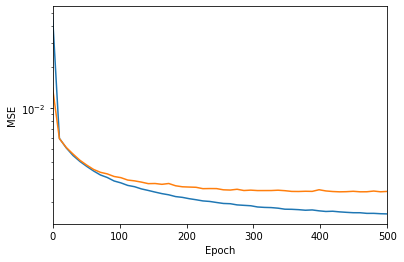

In [ ]:
epoch = np.linspace(0, num_epochs, len(small_train_loss_arr))

plt.figure()
plt.plot(epoch, small_train_loss_arr, label='Train')
plt.plot(epoch, small_val_loss_arr, label='Validate')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.xlim([0, num_epochs])
plt.yscale('log')

The overfitting set up

In [ ]:
learning_rate = 1e-3
lr_decay_rate = 0.2
wr = 1e-4
num_epochs = 500
eval_step = 10

large_model = LargeMLP()
large_model = large_model.to(device)
Loss = nn.MSELoss()
optimizer = torch.optim.Adam(large_model.parameters(), lr=learning_rate, weight_decay=wr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=lr_decay_rate,
                                              patience=10, verbose=True, threshold=1e-4)

In [ ]:
large_train_loss_arr, large_val_loss_arr = model_train(trainloader_small, testloader, large_model, Loss, optimizer, scheduler=scheduler, num_epochs=num_epochs)

Epoch: 0 | Train Loss: 108.5447 | Test Loss: 0.2128
Epoch: 10 | Train Loss: 0.0660 | Test Loss: 0.0204
Epoch: 20 | Train Loss: 0.0156 | Test Loss: 0.0251
Epoch: 30 | Train Loss: 0.0029 | Test Loss: 0.0131
Epoch: 40 | Train Loss: 0.0011 | Test Loss: 0.0140
Epoch: 50 | Train Loss: 0.0008 | Test Loss: 0.0131
Epoch: 60 | Train Loss: 0.0006 | Test Loss: 0.0130
Epoch: 70 | Train Loss: 0.0005 | Test Loss: 0.0130
Epoch 00080: reducing learning rate of group 0 to 2.0000e-04.
Epoch: 80 | Train Loss: 0.0005 | Test Loss: 0.0127
Epoch: 90 | Train Loss: 0.0003 | Test Loss: 0.0127
Epoch: 100 | Train Loss: 0.0002 | Test Loss: 0.0127
Epoch 00107: reducing learning rate of group 0 to 4.0000e-05.
Epoch: 110 | Train Loss: 0.0002 | Test Loss: 0.0127
Epoch: 120 | Train Loss: 0.0002 | Test Loss: 0.0127
Epoch: 130 | Train Loss: 0.0002 | Test Loss: 0.0127
Epoch: 140 | Train Loss: 0.0002 | Test Loss: 0.0127
Epoch 00145: reducing learning rate of group 0 to 8.0000e-06.
Epoch: 150 | Train Loss: 0.0002 | Test Loss

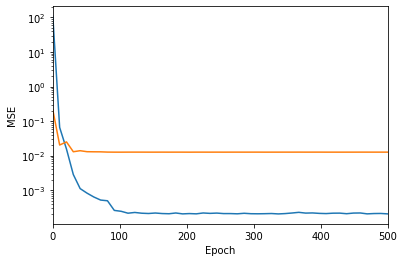

In [ ]:
epoch = np.linspace(0, num_epochs, len(large_train_loss_arr))

plt.figure()
plt.plot(epoch, large_train_loss_arr, label='Train')
plt.plot(epoch, large_val_loss_arr, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.xlim([0, num_epochs])
plt.yscale('log')

# Training the model with optimal parameters

In [ ]:
learning_rate = 1e-4
lr_decay_rate = 0.2
wr = 1e-4
num_epochs = 500
eval_step = 10

model = ADMNN()
model = model.to(device)
Loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=lr_decay_rate,
                                              patience=10, verbose=True, threshold=1e-4)

In [ ]:
train_loss_arr, val_loss_arr = model_train(trainloader, testloader, model, Loss, optimizer, scheduler=scheduler, num_epochs=num_epochs)

Epoch: 0 | Train Loss: 0.0705 | Test Loss: 0.0167
Epoch: 10 | Train Loss: 0.0055 | Test Loss: 0.0069
Epoch: 20 | Train Loss: 0.0043 | Test Loss: 0.0042
Epoch: 30 | Train Loss: 0.0042 | Test Loss: 0.0080
Epoch: 40 | Train Loss: 0.0040 | Test Loss: 0.0055
Epoch: 50 | Train Loss: 0.0036 | Test Loss: 0.0050
Epoch: 60 | Train Loss: 0.0035 | Test Loss: 0.0045
Epoch: 70 | Train Loss: 0.0031 | Test Loss: 0.0033
Epoch: 80 | Train Loss: 0.0029 | Test Loss: 0.0038
Epoch: 90 | Train Loss: 0.0028 | Test Loss: 0.0033
Epoch: 100 | Train Loss: 0.0035 | Test Loss: 0.0076
Epoch 00104: reducing learning rate of group 0 to 2.0000e-05.
Epoch: 110 | Train Loss: 0.0019 | Test Loss: 0.0021
Epoch: 120 | Train Loss: 0.0018 | Test Loss: 0.0021
Epoch: 130 | Train Loss: 0.0018 | Test Loss: 0.0020
Epoch: 140 | Train Loss: 0.0017 | Test Loss: 0.0023
Epoch: 150 | Train Loss: 0.0017 | Test Loss: 0.0019
Epoch: 160 | Train Loss: 0.0016 | Test Loss: 0.0023
Epoch: 170 | Train Loss: 0.0015 | Test Loss: 0.0017
Epoch: 180 | 

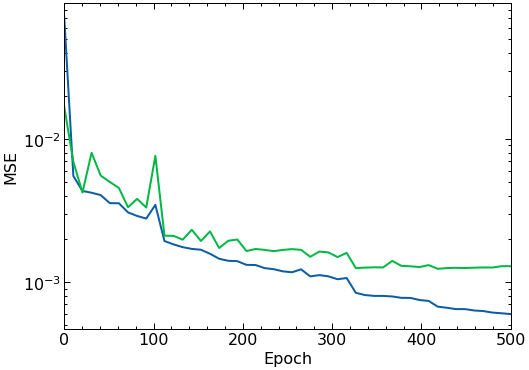

In [ ]:
epoch = np.linspace(0, num_epochs, len(train_loss_arr))

plt.figure()
plt.plot(epoch, train_loss_arr, label='Train')
plt.plot(epoch, val_loss_arr, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.xlim([0, num_epochs])
plt.yscale('log')

# Figure generation

In [ ]:
np.savetxt('small_train.csv', small_train_loss_arr)
np.savetxt('small_val.csv', small_val_loss_arr)
np.savetxt('large_train.csv', large_train_loss_arr)
np.savetxt('large_val.csv', large_val_loss_arr)
np.savetxt('optimal_train.csv', train_loss_arr)
np.savetxt('optimal_val.csv', val_loss_arr)

In [ ]:
small_train_loss_arr = pd.read_csv('small_train.csv', header=None).values
small_val_loss_arr = pd.read_csv('small_val.csv', header=None).values
large_train_loss_arr = pd.read_csv('large_train.csv', header=None).values
large_val_loss_arr = pd.read_csv('large_val.csv', header=None).values
train_loss_arr = pd.read_csv('optimal_train.csv', header=None).values
val_loss_arr = pd.read_csv('optimal_val.csv', header=None).values

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

In [ ]:
!pip install SciencePlots
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(['science', 'nature'])

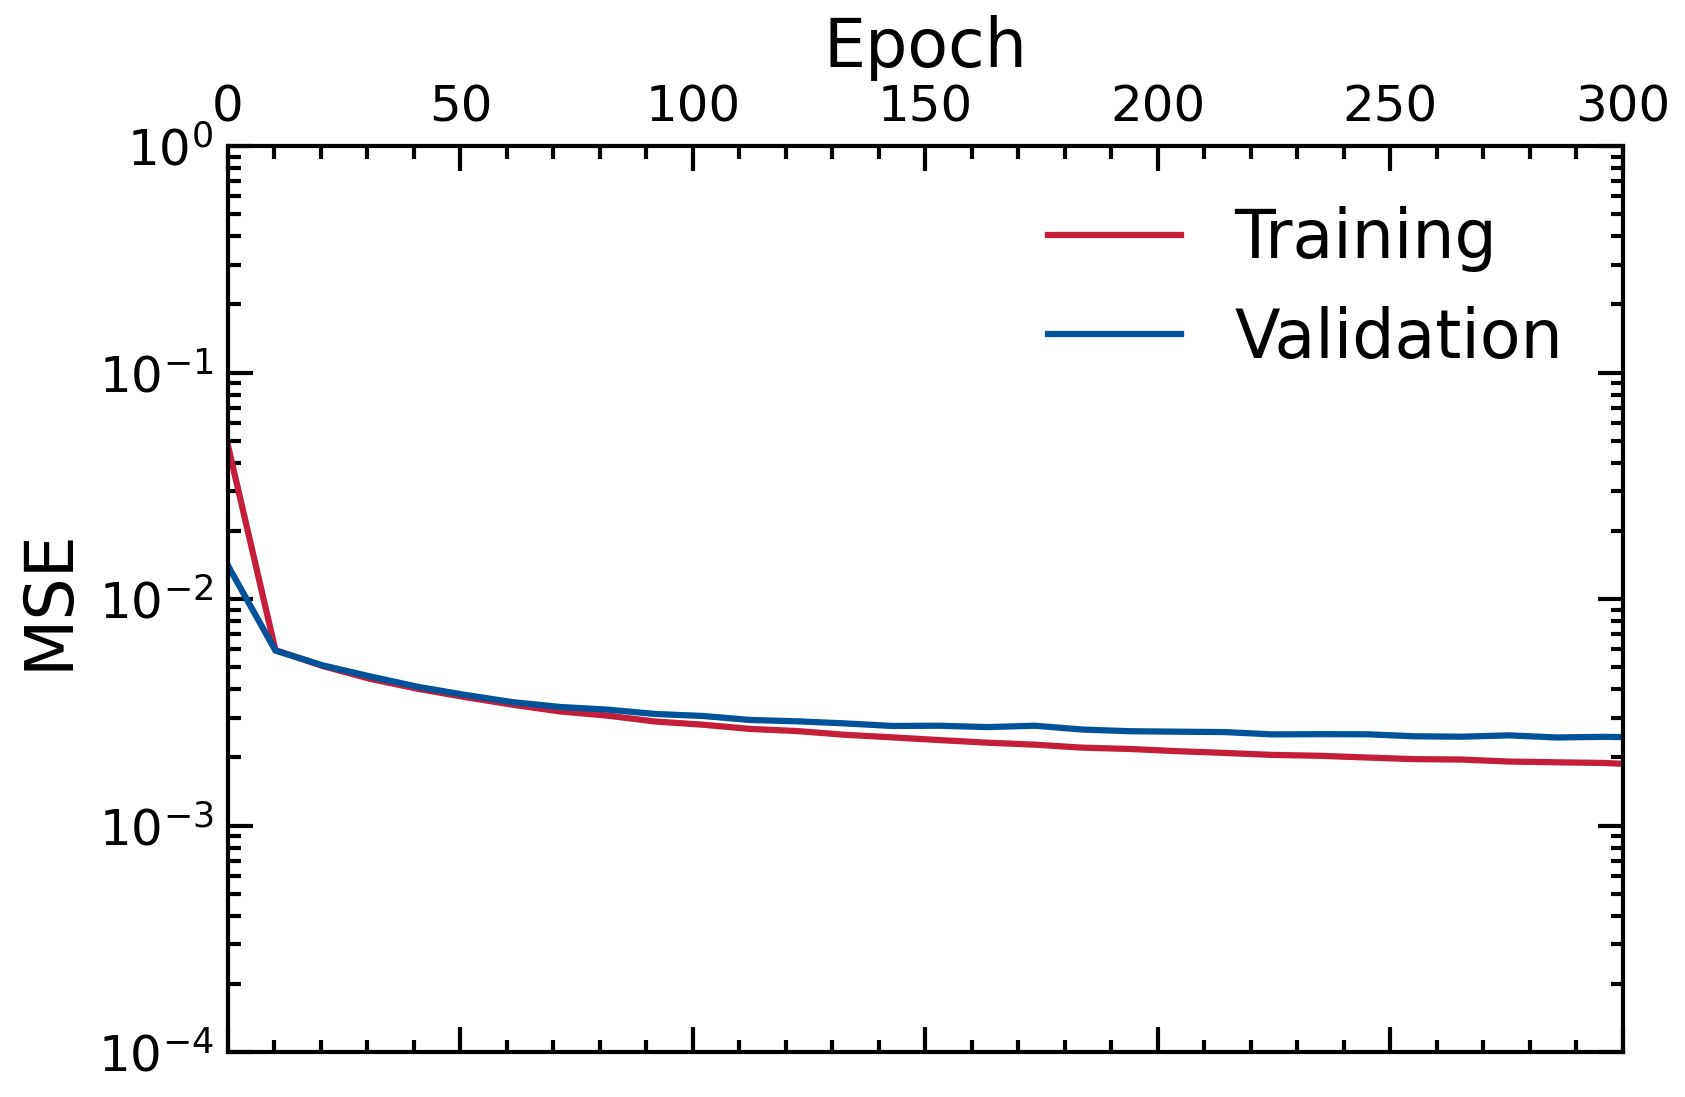

In [ ]:
epoch = np.linspace(0, num_epochs, len(large_train_loss_arr))

plt.style.use(['science', 'notebook'])
plt.rcParams["svg.fonttype"] = "none"

fig, ax = plt.subplots(figsize=(6,4), dpi=300)
plt.plot(epoch, small_train_loss_arr, color='#C41E3A', linewidth=1.5, label='Training')
plt.plot(epoch, small_val_loss_arr, color='#00539B', linewidth=1.5, label='Validation')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.xlim([0, 300])
plt.ylim([1e-4, 1])
plt.yscale('log')
plt.legend(fontsize=16)

plt.tick_params(axis='both', labelsize=12)
ax.xaxis.set_label_position("top")
#ax.yaxis.set_label_position("right")
ax.xaxis.set_tick_params(labeltop=True, labelbottom=False)
#ax.yaxis.set_tick_params(labelright=True, labelleft=False)

In [ ]:
fig.savefig("underfitting.svg", transparent=True)